# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = top_level,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        pciePgpEn  = False,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000400
UpTime       = 1 day, 3:48:50
GitHash      = 0xff123dbf47e096d5f874dd9b3e9a5909aebee138
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = "ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Sat 23 Mar 2024 06:19:41 AM PDT
Builder      = dnajjar"
###################################################


In [3]:
#Run this from a teminal in your localhost without the (!). If you run it here, it will open on rdsrv314 Jupyter server terminal and you won't see it.
#!python -m pyrogue gui --server='localhost:9099'

In [4]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [5]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0xdeadbeef
0xdeadbeef


In [50]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_75000018efb4ab01_SspMonGrp_carrier.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_RegisterControl.yml
Loading batcher configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_BatcherEventBuilder.yml
Loading packet register configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320

In [7]:
period = 1/156.25 # uS
Count = 200/period
print(Count)

31250.0


In [8]:
# helper functions
# clock speed is 168MHz. 1 tick is 0.006 us
def setSR0(width, delay) :
    REGCTRL.SR0Delay1.set(delay)
    REGCTRL.SR0Width1.set(width)
    print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
    print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
    
def setAcq1(width, delay) :
    REGCTRL.AcqDelay1.set(delay)
    REGCTRL.AcqWidth1.set(width)
    print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
    print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
    
def setAcq2(width, delay) :
    REGCTRL.AcqDelay2.set(delay)
    REGCTRL.AcqWidth2.set(width)
    print(f'Acq2 Width set to {REGCTRL.AcqWidth2_us.get():.3f}uS')
    print(f'Acq2 Delay set to {REGCTRL.AcqDelay2_us.get():.3f}uS')    

def setR0(width, delay) :
    REGCTRL.R0Delay.set(delay)
    REGCTRL.R0Width.set(width)
    print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
    print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 

    
def setSync(width, delay) :
    REGCTRL.SyncDelay.set(delay)
    REGCTRL.SyncWidth.set(width)
    print(f'Sync Delay set to {REGCTRL.SyncDelay_us.get():.3f}uS')     

In [48]:
intTime = 160 # 560 = 3.6uS

setR0(5+intTime*2, 10)
setAcq1(intTime, intTime+10)

print(f'-------------------------')
print(f'Acq width = {REGCTRL.AcqWidth1.get()} ticks')
print(f'Acq delay = {REGCTRL.AcqDelay1.get()} ticks')
print(f'R0  width = {REGCTRL.R0Width.get()} ticks')
print(f'R0  delay = {REGCTRL.R0Delay.get()} ticks')
print(f'-------------------------')
AcqEnd = REGCTRL.AcqWidth1.get() + REGCTRL.AcqDelay1.get()
R0End = REGCTRL.R0Width.get() + REGCTRL.R0Delay.get()
print(f'Acq width + delay = {AcqEnd}')
print(f'R0 width + delay = {R0End}')
print(f'-------------------------')
print(f'SR0 acceptable delay > {R0End+1}')
print(f'SR0 acceptable width > {188/period} and less than {200/period - (R0End+1)} for SR0 delay of {R0End+1}')
# Print human-readable values
print(f'-------------------------')
baseline_int_time = REGCTRL.AcqDelay1_us.get() - REGCTRL.R0Delay_us.get()
integration_time = REGCTRL.AcqWidth1_us.get()
print(f'Baseline time:    {baseline_int_time} uS')
print(f'Integration time: {integration_time} uS')
print(f'Sampling done at: {REGCTRL.AcqWidth1_us.get()+REGCTRL.AcqDelay1_us.get()} uS')
print(f'-------------------------')

R0 Width set to 2.080uS
R0 Delay set to 0.064uS
Acq1 Width set to 1.024uS
Acq1 Delay set to 1.088uS
-------------------------
Acq width = 160 ticks
Acq delay = 170 ticks
R0  width = 325 ticks
R0  delay = 10 ticks
-------------------------
Acq width + delay = 330
R0 width + delay = 335
-------------------------
SR0 acceptable delay > 336
SR0 acceptable width > 29375.0 and less than 30914.0 for SR0 delay of 336
-------------------------
Baseline time:    1.024 uS
Integration time: 1.024 uS
Sampling done at: 2.112 uS
-------------------------


# Disable full rate receivers for now

In [8]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

# Single image acquire example

In [9]:
#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [12]:
# Get locked lanes
time.sleep(3)
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xfeffff


In [13]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))


ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [14]:
#ASIC2 FIX?
ASIC2.pipoclk_delay_row0.set(0xf)
ASIC2.pipoclk_delay_row1.set(0xf)
ASIC2.pipoclk_delay_row2.set(0xf)
ASIC2.pipoclk_delay_row3.set(0xf)

In [20]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
root.Trigger()

In [21]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 2 frames
Checkpoint: DataReceiver 1 has 4 frames
Checkpoint: DataReceiver 2 has 4 frames
Checkpoint: DataReceiver 3 has 4 frames


In [22]:
#frame dimensions
for asicIndex in range(root.numOfAsics):
    print(np.shape(frame[asicIndex]))

(192, 384)
(192, 384)
(192, 384)
(192, 384)


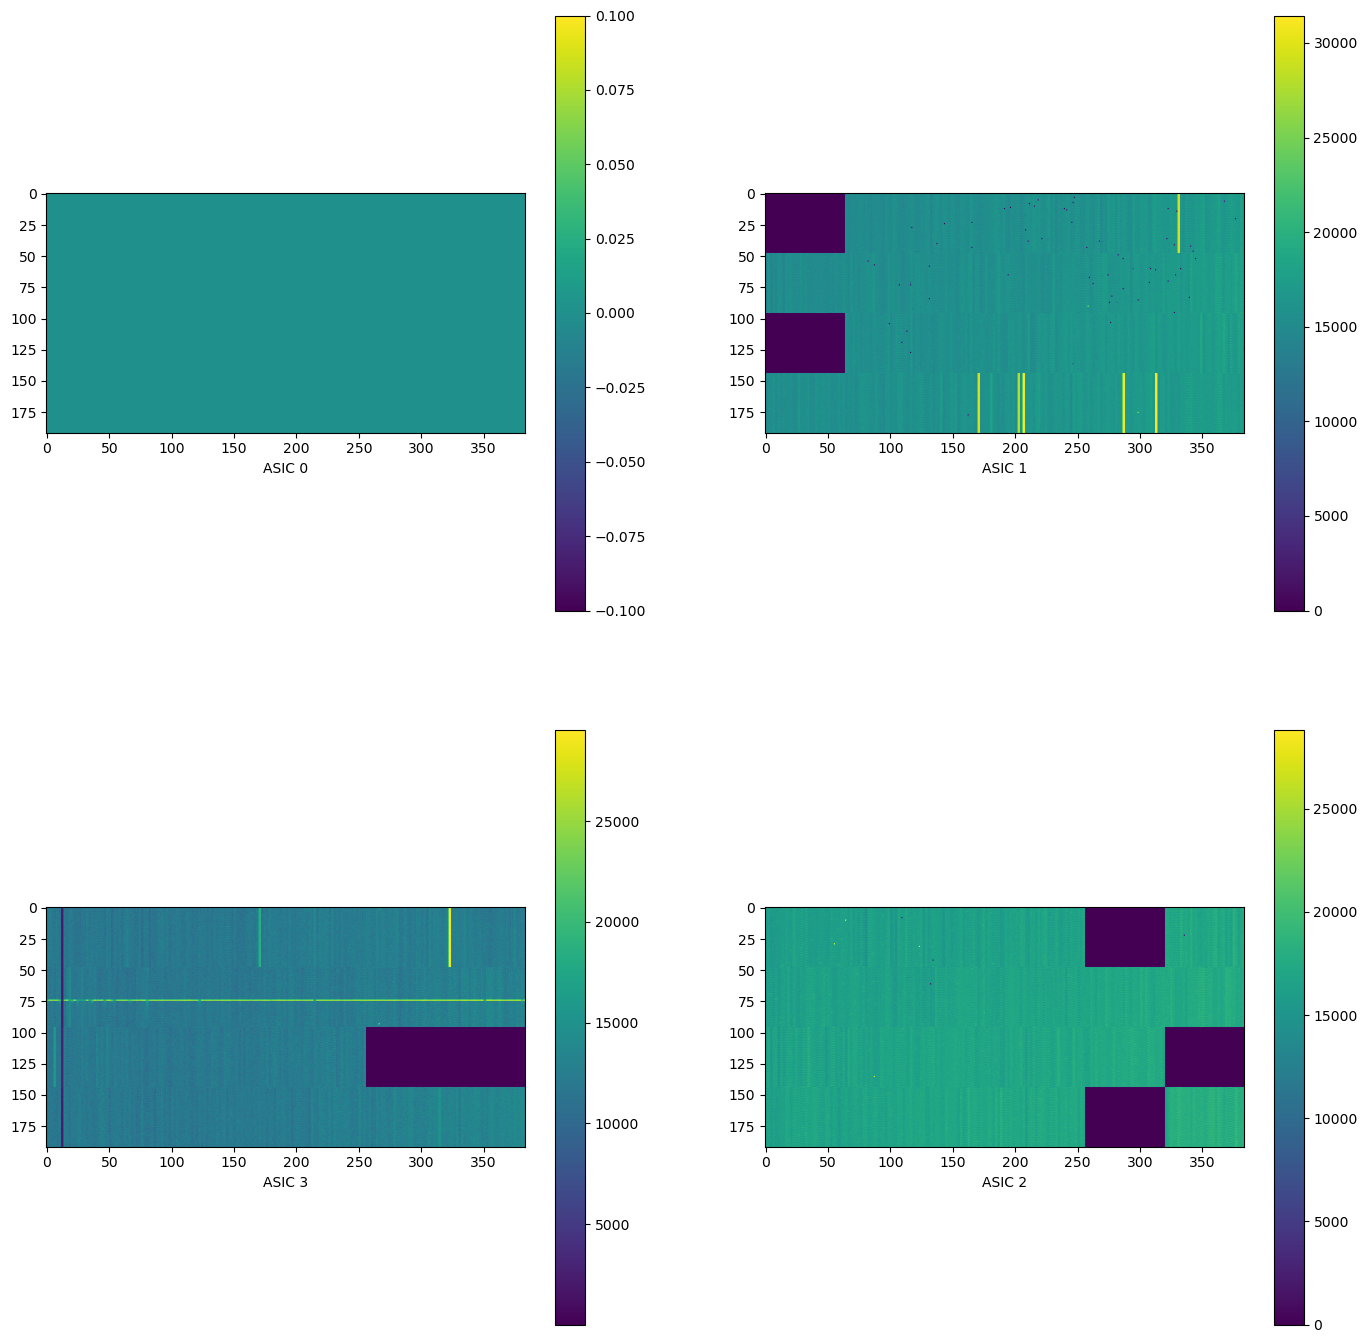

In [23]:
#plot image
plt.subplots(2,2,figsize=(17,17))
for asicIndex in range(root.numOfAsics):
    if asicIndex == 3 :
        plt.subplot(2,2,3)
    elif asicIndex == 2 :
        plt.subplot(2,2,4)
    else :
        plt.subplot(2,2,asicIndex+1)
    
    if np.shape(frame[asicIndex])[0] != 1 :
        plt.imshow(frame[asicIndex])
        plt.xlabel("ASIC {}".format(asicIndex))
        plt.colorbar()
    else :
        plt.xlabel("ASIC {}: No data".format(asicIndex))

# Manipulate ASIC registers

In [24]:
#Manipulate ASIC register
for asicIndex in range(root.numOfAsics) : 
    root.App.Mv2Asic[asicIndex].enable.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(False)

ASIC3.mTest.set(False)

In [ ]:
#Clean up
root.enableDataRcv(False)
root.disableAndCleanAllFullRateDataRcv()
root.enableDataDebug(False)

# Full acquisition of descrambled data in numpy array example

In [30]:
# Perform descrambled acquisition using debug class without writing to file. Has awesome descrambling performance
root.enableAllAsics(False)
root.enableAsic(2, True)
DEBUG2.enableDataDebug(True)
DEBUG2.cleanData()

frames = 100
rate = 100

root.hwTrigger(frames, rate)

# Although the triggers above may have finished, descrambling takes time
while ( frames != DEBUG2.getData().shape[2]) :
    time.sleep(1)
    print("Descrambled {}".format(DEBUG2.getData().shape[2]), end='\r')
print("Data Descrambled")
print(DEBUG2.getData().shape)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed
Data Descrambled
(192, 384, 100)


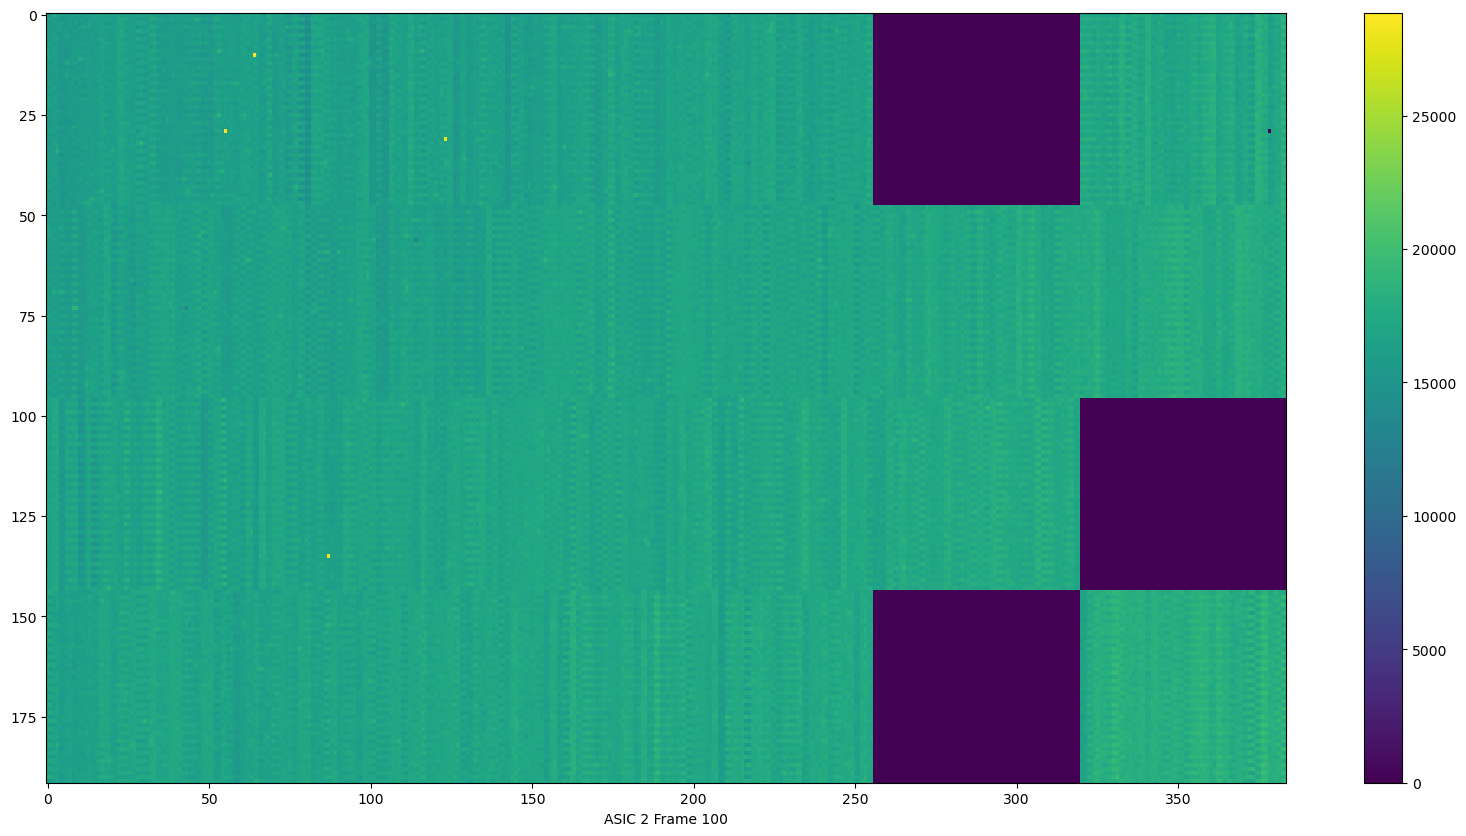

In [31]:
#Display image. Note that Interpolation is enabled. That is similar to auto contrast
plt.figure(figsize = (20,10))
plt.imshow(DEBUG2.getData()[:,:,99], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 2 Frame 100")
plt.colorbar()

In [32]:
# Disable data debug so it does not store data infinitely and crash software
DEBUG2.cleanData()
print(DEBUG2.getData().shape)
DEBUG2.enableDataDebug(False)

(192, 384, 0)


# Using fullRateReceiver class for acquisition with dark application

In [37]:
# Full rate reciever is slower than debug class, but it provides extra processing like applying dark
root.enableFullRateDataRcv(2, True)
root.enableAllAsics(False)
root.enableAsic(2, True)
FULLRATERCV2.cleanData()

In [38]:
# apply dark to next image
FULLRATERCV2.ApplyDark.set(False)
FULLRATERCV2.DarkReady.set(False)
FULLRATERCV2.NumDarkReq.set(1)
FULLRATERCV2.CollectDark.set(True)
while (FULLRATERCV2.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV2.ApplyDark.set(True)



*****Dark ready*****



In [41]:
FULLRATERCV2.cleanData()

#run some triggers and exercise lanes and locks
frames = 100
rate = 1000

root.hwTrigger(frames, rate)

# Although the triggers above may have finished, descrambling takes time
prev = curr = 0
while ( frames != FULLRATERCV2.getData().shape[2]) :
    time.sleep(0.1)
    curr = FULLRATERCV2.getData().shape[2]
    print("Descrambled {} at rate {:.1f} FPS                 ".format(curr, float((curr-prev))/0.1), end='\r')
    prev = FULLRATERCV2.getData().shape[2]
print("\nData Descrambled")
print(FULLRATERCV2.getData().shape)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed
Descrambled 100 at rate 10.0 FPS                 
Data Descrambled
(192, 384, 100)


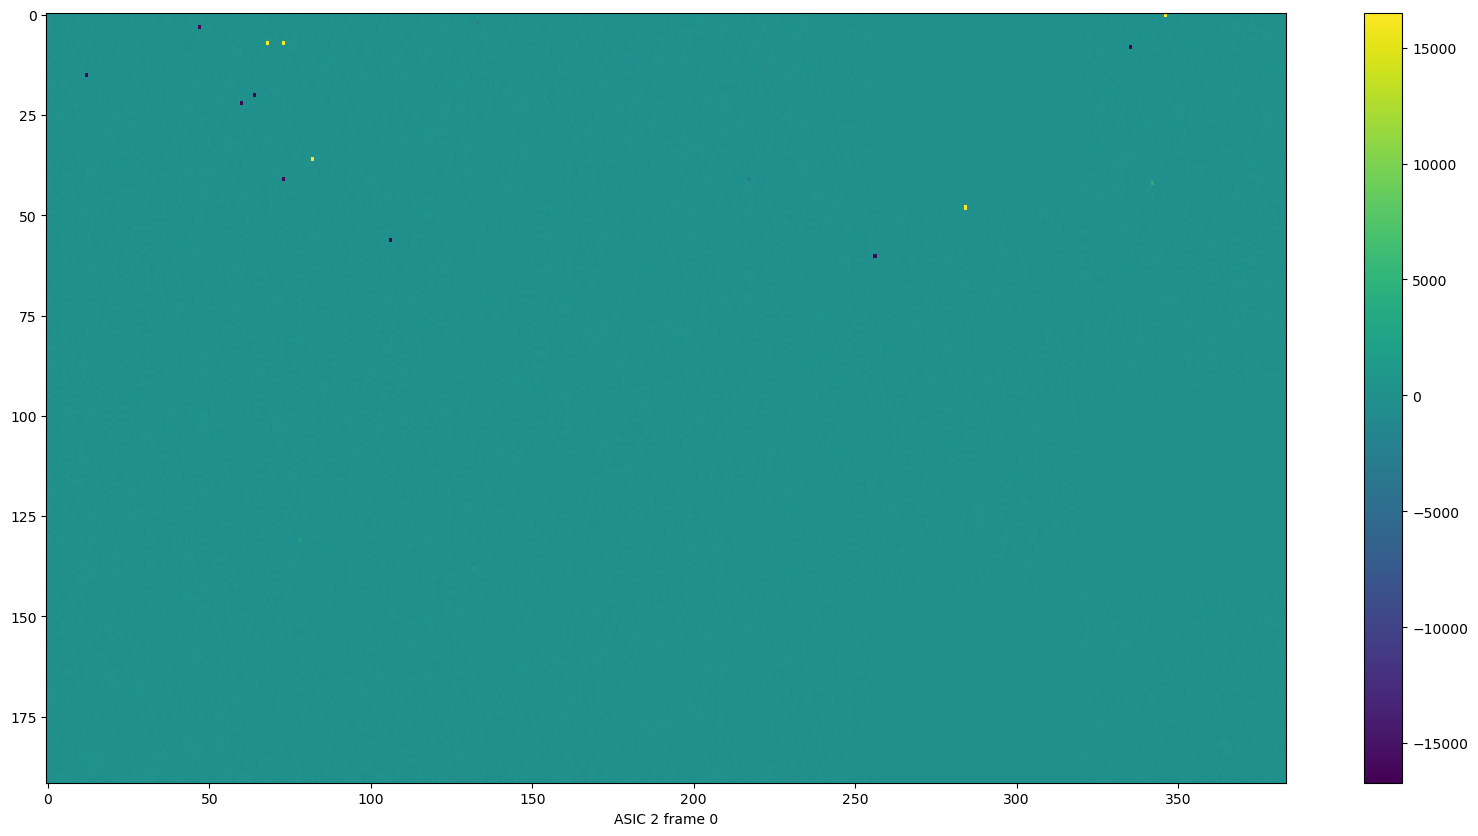

In [42]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV2.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 2 frame 0")
plt.colorbar()

# Charge Injection

In [4]:
# If you want to apply generated in the previous section do not run this!!!
#root.enableFullRateDataRcv(2, True)
#FULLRATERCV3.ApplyDark.set(False)

In [ ]:
FULLRATERCV3.cleanData()

asicIndex = 2
chargeInjectionFirstCol = 50
chargeInjectionLastCol = 100
chargeInjectionPulserValue = 200
APP.prepareChargeInjection(asicIndex, chargeInjectionFirstCol, chargeInjectionLastCol, chargeInjectionPulserValue)
root.Trigger()

In [55]:
print(FULLRATERCV2.getData().shape)

(192, 384, 453)


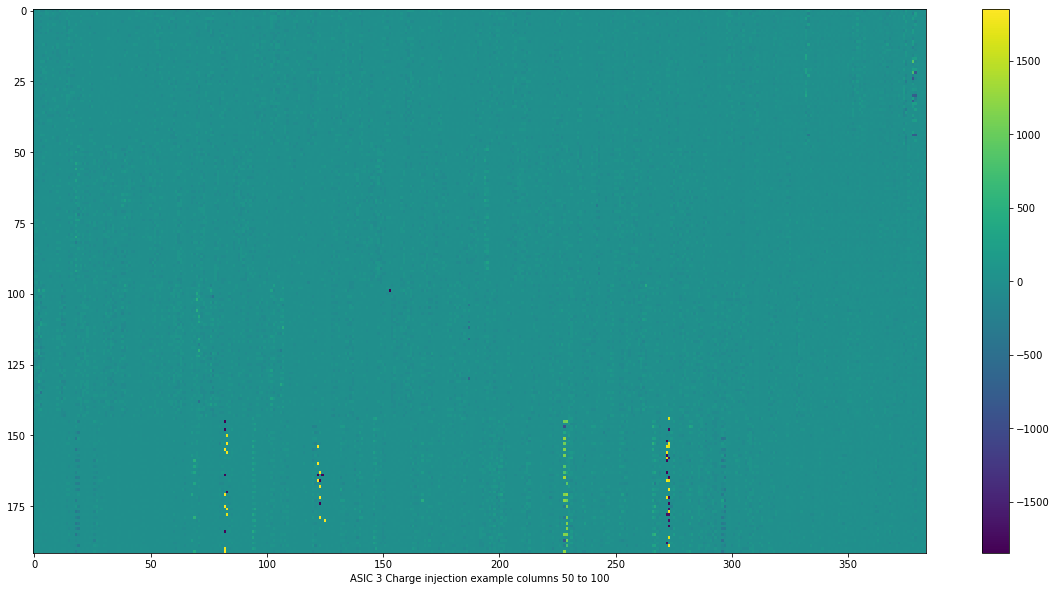

In [27]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 Charge injection example columns 50 to 100")
plt.colorbar()

In [ ]:
APP.chargeInjectionCleanup(3)

# With dark multiple frame acquisition

In [29]:
# If dark was disabled in the previous section you need to run dark again
FULLRATERCV3.cleanData()

numberOfTriggers = 100
for asicIndex in range(numberOfTriggers):
    root.Trigger()
    print("{}".format(asicIndex+1), end='\r')
    time.sleep(0.01)

In [34]:
# Run multiple times to see processed frames
np.shape(FULLRATERCV3.getData())

(192, 384, 99)

In [31]:
# Although the triggers above may have finished, descrambling takes time
while ( numberOfTriggers != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)
    print("Processed {}".format(FULLRATERCV3.getData().shape[2]), end='\r')
print("Data processed")
print(FULLRATERCV3.getData().shape)

KeyboardInterrupt: 

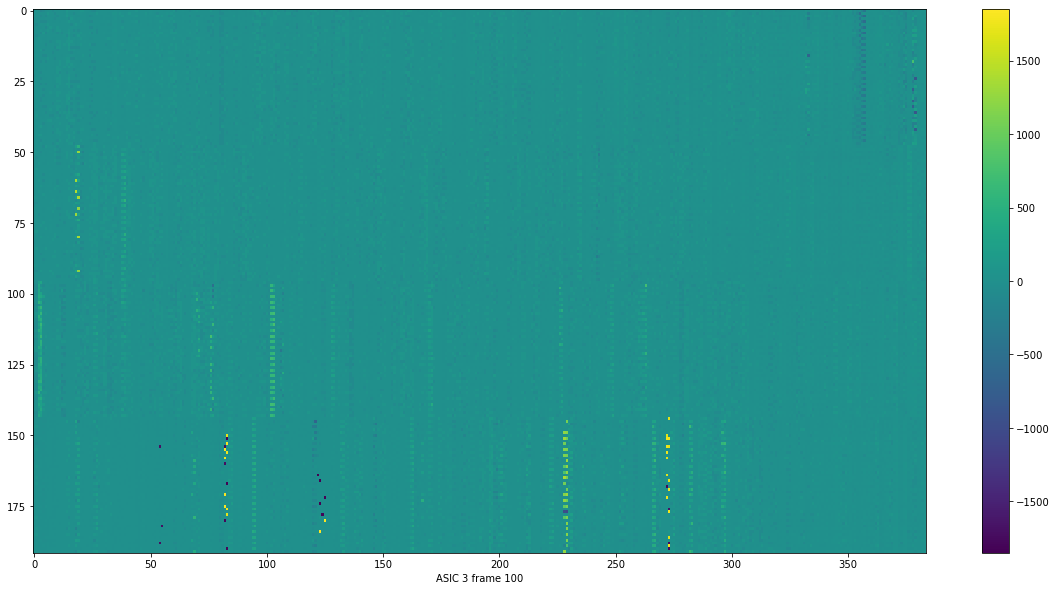

In [33]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,98], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 100")
plt.colorbar()

In [39]:
# cleanup
# root.disableAndCleanAllFullRateDataRcv()

# ADC Response with external DAC waveform

In [35]:
# User ASIC 3
ASIC3.mTest.set(True)

In [36]:
first = 0x0
# min 0V, Max 2.5V
last = 1048575
step = 65535
DAC.setupFastDacWaveform(first, last, step)

In [37]:
FULLRATERCV3.cleanData()

#run some triggers and exercise lanes and locks
frames = 16
rate = 2
root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 16
Stop Triggers command executed


In [38]:
# Although the triggers above may have finished, descrambling takes time
while ( frames != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)
    print("Processed {}".format(FULLRATERCV3.getData().shape[2]), end='\r')
print("Data processed")
print(FULLRATERCV3.getData().shape)

Data processed
(192, 384, 16)


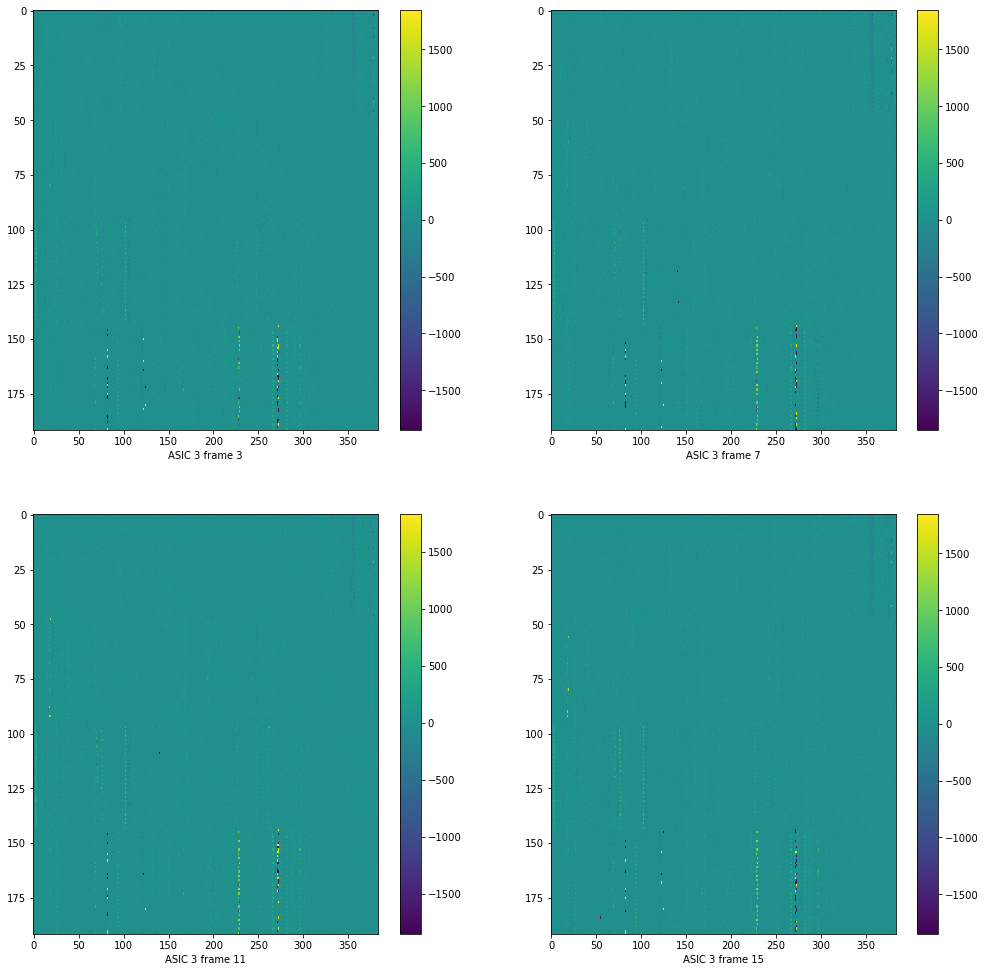

In [39]:
#plot images
plt.subplots(2,2,figsize=(17,17))
for imageIndex in range(4):
    plt.subplot(2,2,imageIndex+1)
     
    plt.imshow(FULLRATERCV3.getData()[:,:,imageIndex * 4 + 3], interpolation='nearest', aspect='auto')
    plt.xlabel("ASIC 3 frame {}".format(imageIndex * 4 + 3))
    plt.colorbar()

In [40]:
DAC.cleanupFastDacWaveform()
ASIC3.mTest.set(False)

# Laser with all four ASICs

In [4]:
#ASIC2 FIX?
ASIC2.pipoclk_delay_row0.set(0x7)
ASIC2.pipoclk_delay_row1.set(0x8)
ASIC2.pipoclk_delay_row2.set(0x8)
ASIC2.pipoclk_delay_row3.set(0x8)

In [5]:
# Full rate reciever is slower than debug class, but it provides extra processing like applying dark
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)
root.enableFullRateDataRcv(3, True)
root.enableFullRateDataRcv(2, True)
root.enableFullRateDataRcv(1, True)
root.enableFullRateDataRcv(0, True)
root.enableAllAsics(True)

# apply dark to next image
FULLRATERCV3.ApplyDark.set(False)
FULLRATERCV3.DarkReady.set(False)
FULLRATERCV3.NumDarkReq.set(1)
FULLRATERCV3.CollectDark.set(True)
while (FULLRATERCV3.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV3.ApplyDark.set(True)

# apply dark to next image
FULLRATERCV2.ApplyDark.set(False)
FULLRATERCV2.DarkReady.set(False)
FULLRATERCV2.NumDarkReq.set(1)
FULLRATERCV2.CollectDark.set(True)
while (FULLRATERCV2.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV2.ApplyDark.set(True)

# apply dark to next image
FULLRATERCV1.ApplyDark.set(False)
FULLRATERCV1.DarkReady.set(False)
FULLRATERCV1.NumDarkReq.set(1)
FULLRATERCV1.CollectDark.set(True)
while (FULLRATERCV1.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV1.ApplyDark.set(True)

# apply dark to next image
FULLRATERCV0.ApplyDark.set(False)
FULLRATERCV0.DarkReady.set(False)
FULLRATERCV0.NumDarkReq.set(1)
FULLRATERCV0.CollectDark.set(True)
while (FULLRATERCV0.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV0.ApplyDark.set(True)


*****Dark ready*****


*****Dark ready*****


*****Dark ready*****


*****Dark ready*****



In [52]:
FULLRATERCV3.cleanData()
FULLRATERCV2.cleanData()
FULLRATERCV1.cleanData()
FULLRATERCV0.cleanData()


#run some triggers and exercise lanes and locks
root.Trigger()

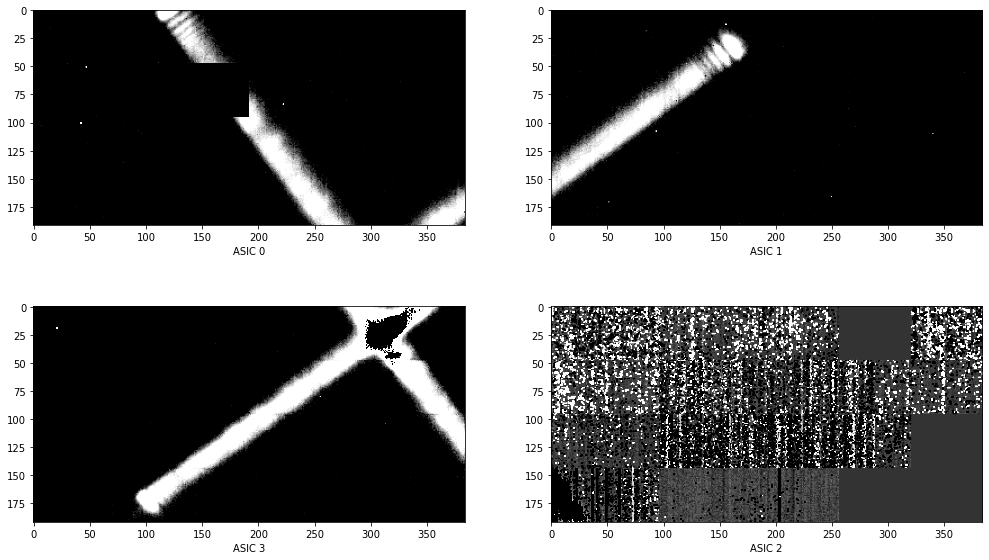

In [54]:
# Display images

plt.subplots(2,2,figsize=(17,10))
for asicIndex in range(root.numOfAsics):
    if asicIndex == 3 :
        plt.subplot(2,2,3)
        plt.imshow(FULLRATERCV3.getData()[:,:,0], cmap='Greys',  vmax = -100, vmin = -500)
        plt.xlabel("ASIC 3")
    elif asicIndex == 2 :
        plt.subplot(2,2,4)
        plt.imshow(FULLRATERCV2.getData()[:,:,0], cmap='Greys',  vmax = 100, vmin = -500)
        plt.xlabel("ASIC 2")
    elif asicIndex == 1 :
        plt.subplot(2,2,asicIndex+1)
        plt.imshow(np.rot90(FULLRATERCV1.getData()[:,:,0],2), cmap='Greys',  vmax = -100, vmin = -500)
        plt.xlabel("ASIC 1")
    else :
        plt.subplot(2,2,asicIndex+1)
        plt.imshow(np.rot90(FULLRATERCV0.getData()[:,:,0],2), cmap='Greys',  vmax = -100, vmin = -500)
        plt.xlabel("ASIC 0")

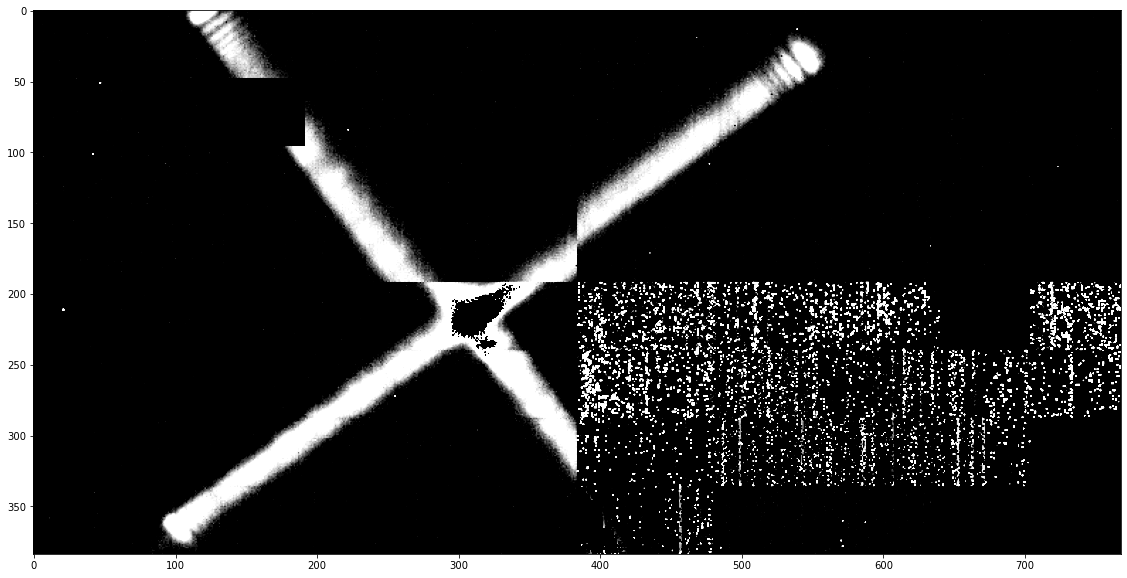

In [58]:
#plot all images together

firstRow  = np.concatenate((np.rot90(FULLRATERCV0.getData()[:,:,0],2), np.rot90(FULLRATERCV1.getData()[:,:,0],2)), axis=1)
lastRow   = np.concatenate((FULLRATERCV3.getData()[:,:,0], FULLRATERCV2.getData()[:,:,0]), axis=1)
fullImage = np.concatenate((firstRow, lastRow), axis=0)

plt.figure(figsize = (20,10))
plt.imshow(fullImage, cmap='Greys',  vmax = -100, vmin = -500)

In [63]:
np.save("/afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/Dawood", fullImage)

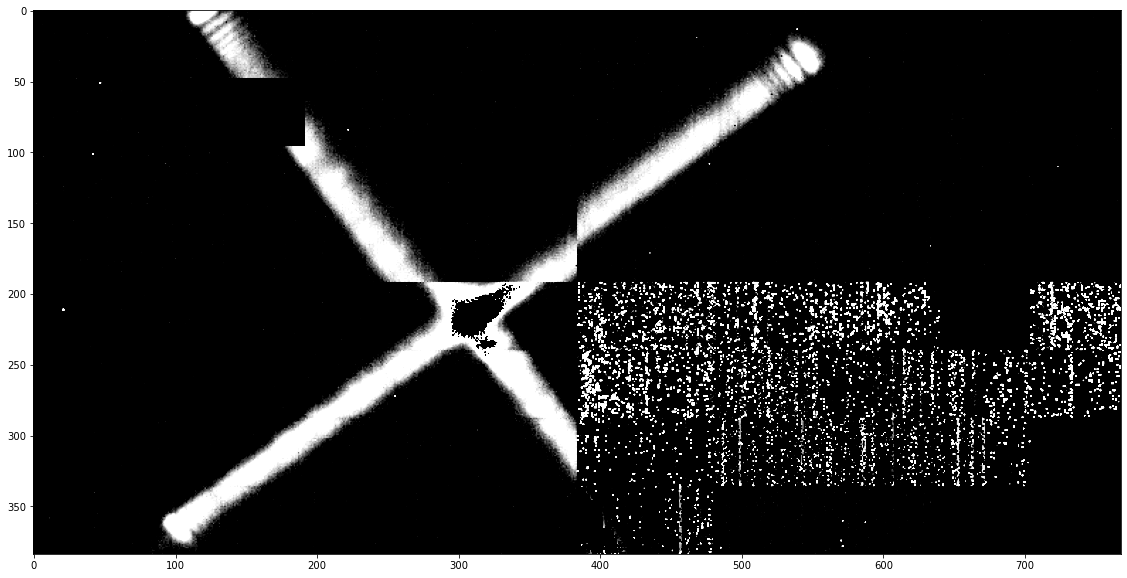

In [2]:
x = np.load("/afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/image.npy")
plt.figure(figsize = (20,10))
plt.imshow(x, cmap='Greys',  vmax = -100, vmin = -500)

In [24]:
x[192:,384:] = 0
inserted = x
for i in range(20):
    inserted = np.insert(inserted, 192, 0, axis=0)

for i in range(20):
    inserted = np.insert(inserted, 384, 0, axis=1)

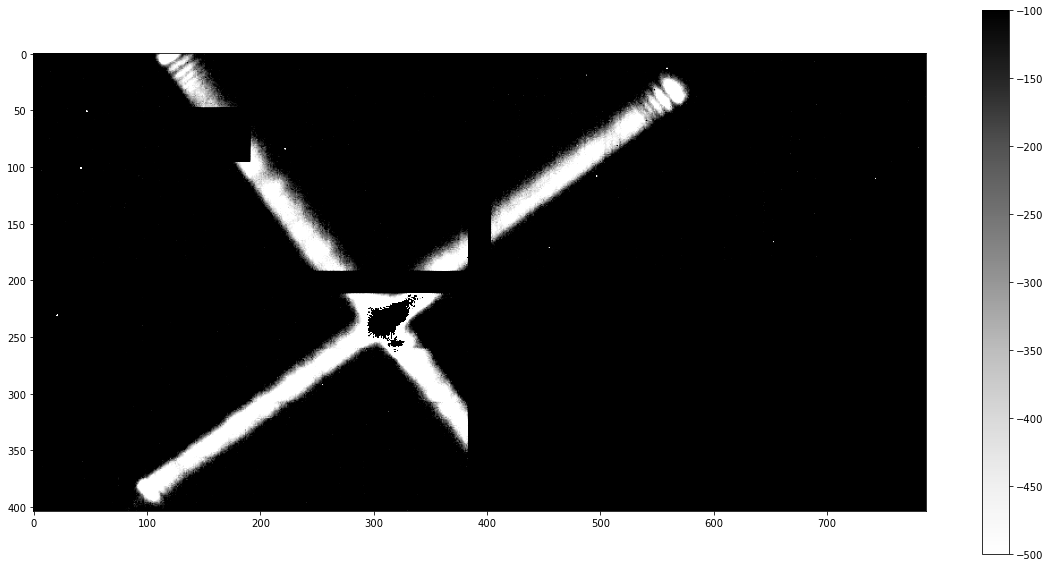

In [34]:
plt.figure(figsize = (20,10))
plt.imshow(inserted, cmap='Greys',  vmax = -100, vmin = -500)
plt.colorbar()

# ADC Response with external DAC single writes

In [41]:
# User ASIC 3
DAC.cleanupFastDacWaveform()
FULLRATERCV3.cleanData()
ASIC3.mTest.set(True)

In [42]:
#write to DAC
value = 0xfffff
DAC.FastDac.DacValue.set(value)
print("Fast DAC set to {}V".format(DAC.FastDac.DacValueV.get()))

Fast DAC set to 2.500V


In [50]:
root.Trigger()

In [51]:
print(FULLRATERCV3.getData().shape)

(192, 384, 1)


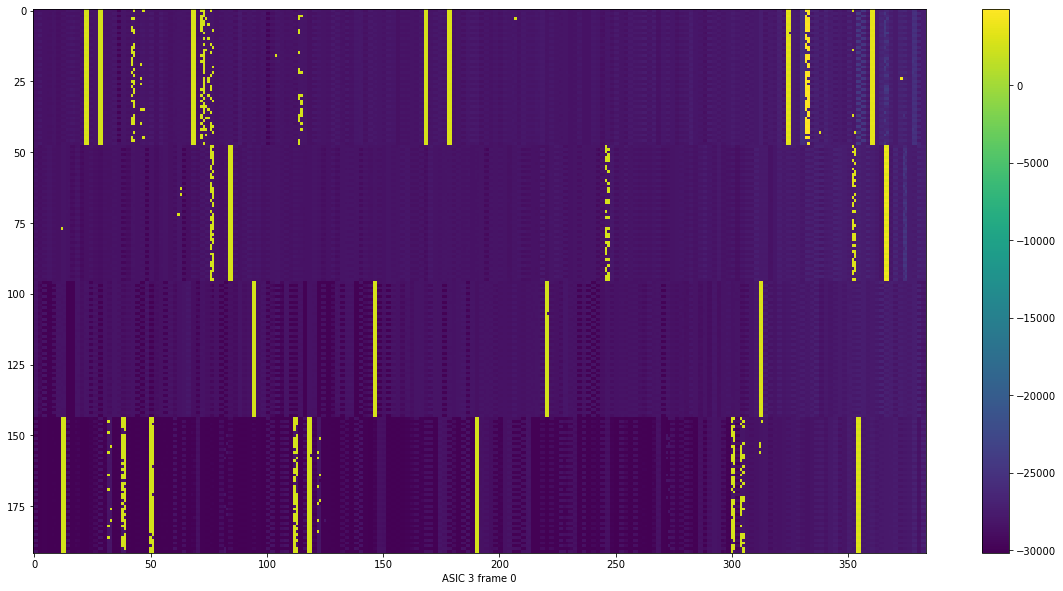

In [52]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 0")
plt.colorbar()

# Keithley Readings

In [53]:
# If you want to use these helper function from other environments
# you need to run the following command from the command line
# export EPICS_CA_ADDR_LIST=134.79.228.141:5064

# imports and helper functions
from epics import caget, caput
import time

def getKeithleyCurrent() :
    return caget("keithley2400:measCurrAI")

def keithleyEnable(enable):
    caput("keithley2400:enableBO", enable)
    
def getKeithleyVoltage() :
    return caget("keithley2400:measVoltAI")

def decrementKeithleyVoltage() :
    value = caget("keithley2400:measVoltAI.VAL")
    caput('keithley2400:setVoltAO.VAL', value - 1)

def incrementKeithleyVoltage() :
    value = caget("keithley2400:measVoltAI.VAL")
    caput('keithley2400:setVoltAO.VAL', value + 1)

In [54]:
# Get Keithley voltage and current
print("Keithley voltage set to {}".format(getKeithleyVoltage()))

for i in range(10):
    print("Consumed current is: {}".format(getKeithleyCurrent()))
    time.sleep(1)

Keithley voltage set to -21.0
Consumed current is: -8.270824e-07
Consumed current is: -8.26473e-07
Consumed current is: -8.26473e-07
Consumed current is: -8.253609e-07
Consumed current is: -8.248513e-07
Consumed current is: -8.244324e-07
Consumed current is: -8.240092e-07
Consumed current is: -8.240092e-07
Consumed current is: -8.231624e-07
Consumed current is: -8.228303e-07


In [16]:
# Increment Keithley voltage
incrementKeithleyVoltage()
time.sleep(5) # voltage is scanned from hardware every 5 seconds
getKeithleyVoltage()

-20.0

In [17]:
# Decrement Keithley voltage
decrementKeithleyVoltage()
time.sleep(5)
getKeithleyVoltage()

-21.0

# Control waveform delays

In [18]:
# helper functions
# clock speed is 168MHz. 1 tick is 0.006 us
def setSR0(width, delay) :
    REGCTRL.SR0Delay1.set(delay)
    REGCTRL.SR0Width1.set(width)
    print(f'SR0 Width set to {REGCTRL.SR0Width1_us.get():.3f}uS')
    print(f'SR0 Delay set to {REGCTRL.SR0Delay_us.get():.3f}uS')
    
def setAcq1(width, delay) :
    REGCTRL.AcqDelay1.set(delay)
    REGCTRL.AcqWidth1.set(width)
    print(f'Acq1 Width set to {REGCTRL.AcqWidth1_us.get():.3f}uS')
    print(f'Acq1 Delay set to {REGCTRL.AcqDelay1_us.get():.3f}uS')
    
def setAcq2(width, delay) :
    REGCTRL.AcqDelay2.set(delay)
    REGCTRL.AcqWidth2.set(width)
    print(f'Acq2 Width set to {REGCTRL.AcqWidth2_us.get():.3f}uS')
    print(f'Acq2 Delay set to {REGCTRL.AcqDelay2_us.get():.3f}uS')    

def setR0(width, delay) :
    REGCTRL.R0Delay.set(delay)
    REGCTRL.R0Width.set(width)
    print(f'R0 Width set to {REGCTRL.R0Width_us.get():.3f}uS')
    print(f'R0 Delay set to {REGCTRL.R0Delay_us.get():.3f}uS') 

    
def setSync(width, delay) :
    REGCTRL.SyncDelay.set(delay)
    REGCTRL.SyncWidth.set(width)
    print(f'Sync Delay set to {REGCTRL.SyncDelay_us.get():.3f}uS')     

In [37]:
Width = 5
Delay = 10
setSR0(Width, Delay)
setAcq1(Width, Delay)
setAcq2(Width, Delay)
setR0(Width, Delay)
setSync(Width, Delay)

SR0 Width set to 0.030uS
SR0 Delay set to 0.060uS
Acq1 Width set to 0.032uS
Acq1 Delay set to 0.064uS
Acq2 Width set to 0.032uS
Acq2 Delay set to 0.064uS
R0 Width set to 0.032uS
R0 Delay set to 0.064uS
Sync Delay set to 0.060uS


# Writing data to a rogue format file on full rate

In [3]:
root.enableDataRcv(False)
root.disableAndCleanAllFullRateDataRcv()
root.enableAllAsics(False)
root.enableDataDebug(False)

root.enableAsic(3, True)

ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/test.dat"
rate = 5000 # HZ
frames = 70000

root.acquireToFile(filename, frames, rate)

Acquisition started: filename: /u1/ePixHRM320k/acquisition/test.dat, rate: 5000, #frames:1000
Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 1000
Stop Triggers command executed
Received on channel 0 0 frames...
Received on channel 1 0 frames...
Received on channel 2 0 frames...
Received on channel 3 1000 frames...
Waiting for file to close...
Acquisition complete and file closed


# Reading data from a rogue format file

In [5]:
# Has good performance
  
ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/test.dat"

root.readFromFile(filename)

In [6]:
np.shape(root.readerReceiver.getData())

(192, 384, 1000)

# Convert to HDF5

In [3]:
"""
CONVERT: DAT TO HDF5
"""
ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/test.dat"

# --- FAST MULTI-CORE METHOD --- #
# Note: For 130k frames at x20 cores, takes ~1.5 hours
DAT_to_HDF5 = '{}/imgProc/read_image_from_file_ePixMHrv2.py'.format(rootTopLevel)
print('Waiting... runing in process... when * changes to a number then done')
%run {DAT_to_HDF5} {filename} {"--cores=100 --help"}
print("HDF5 generation complete")

Waiting... runing in process... when * changes to a number then done
Starting to get data set 0
Read 1000 frames
Camera  ePixHrMv2  selected.
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
Camera  ePixHrMv2  selected.
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2


KeyboardInterrupt: 

HDF5 generation complete
